In [1]:
import pandas as pd
import json
import os
import numpy as np
import requests
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from joblib import dump, load
from functions import num_to_cik
from functions import Convertor_Multiple
from functions import na_max
from functions import train_random_forest
from functions import save_model
from functions import load_model
from functions import evaluate_model
from functions import df_info

In [2]:
df = pd.read_csv('df_clustered_80.csv')

In [3]:
df = df[['CIK', 'EntityName', 'Form', 'FP', 'End', 'Filed', 'Frame','Assets','EarningsPerShareBasic','GrossProfit','NetIncomeLoss']]

### STEP01: Choose Frames

In [4]:
def Step01_CikFramesEpsDrop(df):
    
    years_quarters = [
            "CY2012Q1", "CY2012Q2", "CY2012Q3", "CY2012Q4",
            "CY2013Q1", "CY2013Q2", "CY2013Q3", "CY2013Q4",
            "CY2014Q1", "CY2014Q2", "CY2014Q3", "CY2014Q4",
            "CY2015Q1", "CY2015Q2", "CY2015Q3", "CY2015Q4",
            "CY2016Q1", "CY2016Q2", "CY2016Q3", "CY2016Q4",
            "CY2017Q1", "CY2017Q2", "CY2017Q3", "CY2017Q4",
            "CY2018Q1", "CY2018Q2", "CY2018Q3", "CY2018Q4",
            "CY2019Q1", "CY2019Q2", "CY2019Q3", "CY2019Q4",
            "CY2020Q1", "CY2020Q2", "CY2020Q3", "CY2020Q4",
            "CY2021Q1", "CY2021Q2", "CY2021Q3", "CY2021Q4",
            "CY2022Q1", "CY2022Q2", "CY2022Q3", "CY2022Q4",
            "CY2023Q1", "CY2023Q2", "CY2023Q3", "CY2023Q4"
        ]

    df = df[df['Frame'].isin(years_quarters)]
    df = df.sort_values(['CIK','Frame'])
    df = df.drop(['EntityName', 'Form', 'FP', 'End', 'Filed'],axis=1)
    df = df.dropna(subset=['EarningsPerShareBasic'])

    return df

In [5]:
df_1 = Step01_CikFramesEpsDrop(df)

In [6]:
df_1.to_csv('df_1.csv',index=False,mode='w')

### STEP02: Percentage Difference

In [7]:
df_1 = pd.read_csv('df_1.csv')

In [8]:
def Step02_PercentageDifference(df):
    df_2 = df[df.columns[2:]].pct_change(fill_method=None).round(3)
    df_1 = df[df.columns[:2]]
    df = pd.concat([df_1,df_2],axis=1)
    pivoted = pd.pivot_table(df, index=['CIK', 'Frame'])
    rows_to_drop = pivoted.groupby(level=0).head(1).index
    pivoted = pivoted.drop(rows_to_drop)
    pivoted = pivoted.reset_index()
    pivoted = pivoted.fillna(0)
    return pivoted

In [9]:
df_2 = Step02_PercentageDifference(df_1)

In [10]:
df_2.to_csv('df_2.csv',index=False,mode='w',na_rep='NaN')

### STEP03: Pivot Lag

In [11]:
df_2 = pd.read_csv('df_2.csv')

In [12]:
def Step03_PivotLag(df, level_1, level_2, shift):
    shift_periods = [-i for i in range(1, shift + 1)]
    pivoted = pd.pivot_table(df, index=[level_1, level_2])
    new_columns = {}

    for col in pivoted.columns:
        for period in shift_periods:
            new_col_name = f'{col}_{abs(period)}'
            new_columns[new_col_name] = pivoted.groupby(level=level_1)[col].shift(periods=period)

    # Use pd.concat to join all new columns at once
    pivoted = pd.concat([pivoted, pd.DataFrame(new_columns, index=pivoted.index)], axis=1)
    desired_order = sorted(list(pivoted.columns))
    pivoted = pivoted[desired_order]
    pivoted = pivoted.reset_index()
    return pivoted

In [13]:
df_3 = Step03_PivotLag(df_2,'CIK','Frame',2)

In [14]:
df_3.to_csv('df_3.csv',index=False,mode='w',na_rep='NaN')

### STEP04: Target & DropNA

In [36]:
df_3 = pd.read_csv('df_3.csv')

In [37]:
df_3

,CIK,Frame,Assets,Assets_1,Assets_2,EarningsPerShareBasic,EarningsPerShareBasic_1,EarningsPerShareBasic_2,GrossProfit,GrossProfit_1,GrossProfit_2,NetIncomeLoss,NetIncomeLoss_1,NetIncomeLoss_2
0,89439,CY2012Q3,-0.183,0.062,0.035,-0.128,0.439,-0.203,-0.095,0.013,0.177,-0.134,0.055,0.601
1,89439,CY2012Q4,0.062,0.035,0.059,0.439,-0.203,2.489,0.013,0.177,0.056,0.055,0.601,2.479
2,89439,CY2013Q1,0.035,0.059,0.042,-0.203,2.489,-0.567,0.177,0.056,-0.106,0.601,2.479,-0.563
3,89439,CY2013Q2,0.059,0.042,-0.010,2.489,-0.567,-0.606,0.056,-0.106,-0.092,2.479,-0.563,-0.614
4,89439,CY2013Q3,0.042,-0.010,0.028,-0.567,-0.606,0.571,-0.106,-0.092,0.193,-0.563,-0.614,0.606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1887,310764,CY2022Q3,-0.001,0.025,-0.001,0.249,-0.315,0.054,-0.016,0.163,-0.068,0.244,-0.310,0.052
1888,310764,CY2022Q4,0.025,-0.001,0.016,-0.315,0.054,0.250,0.163,-0.068,0.055,-0.310,0.052,0.247
1889,310764,CY2023Q1,-0.001,0.016,0.017,0.054,0.250,-0.067,-0.068,0.055,-0.007,0.052,0.247,-0.062
1890,310764,CY2023Q2,0.016,0.017,NaN,0.250,-0.067,NaN,0.055,-0.007,NaN,0.247,-0.062,NaN


In [38]:
def Step04_TargetDropNA(df,lvl1,lvl2,last):
    df = pd.pivot_table(df, index=[lvl1,lvl2])
    df['target_lag'] = df.groupby(level=lvl1)[last].shift(-1)
    df['target'] = 0
    df.loc[df[last] < df[df.columns[-2]], 'target'] = 1
    df.loc[df[last] > df[df.columns[-2]], 'target'] = 0
    df = df.drop('target_lag',axis=1)
    df = df.reset_index()
    df = df.drop(lvl1,axis=1)
    df = df.drop(lvl2,axis=1)
    df = df.dropna()
    df = df.replace([np.inf, -np.inf, np.nan], 0).round(2)
    return df

In [39]:
df_4 = Step04_TargetDropNA(df_3,'CIK','Frame','EarningsPerShareBasic_2')

In [41]:
df_4.to_csv('df_4.csv',index=False,mode='w',na_rep='NaN')

In [42]:
df_4

,Assets,Assets_1,Assets_2,EarningsPerShareBasic,EarningsPerShareBasic_1,EarningsPerShareBasic_2,GrossProfit,GrossProfit_1,GrossProfit_2,NetIncomeLoss,NetIncomeLoss_1,NetIncomeLoss_2,target
0,-0.18,0.06,0.04,-0.13,0.44,-0.20,-0.10,0.01,0.18,-0.13,0.06,0.60,1
1,0.06,0.04,0.06,0.44,-0.20,2.49,0.01,0.18,0.06,0.06,0.60,2.48,0
2,0.04,0.06,0.04,-0.20,2.49,-0.57,0.18,0.06,-0.11,0.60,2.48,-0.56,0
3,0.06,0.04,-0.01,2.49,-0.57,-0.61,0.06,-0.11,-0.09,2.48,-0.56,-0.61,1
4,0.04,-0.01,0.03,-0.57,-0.61,0.57,-0.11,-0.09,0.19,-0.56,-0.61,0.61,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,0.04,-0.00,-0.00,-0.51,1.01,0.25,-0.10,0.03,-0.02,-0.51,1.03,0.24,0
1886,-0.00,-0.00,0.02,1.01,0.25,-0.32,0.03,-0.02,0.16,1.03,0.24,-0.31,1
1887,-0.00,0.02,-0.00,0.25,-0.32,0.05,-0.02,0.16,-0.07,0.24,-0.31,0.05,1
1888,0.02,-0.00,0.02,-0.32,0.05,0.25,0.16,-0.07,0.06,-0.31,0.05,0.25,0


### Step05: Merge in Chunks

In [43]:
def process_in_chunks(df, key_column_1, key_column_2, number_of_shifts, n):
    # Ensure the key columns are at the front
    cols = [key_column_1, key_column_2] + [col for col in df if col not in [key_column_1, key_column_2]]
    df = df[cols]
    
    # Calculate the number of columns per chunk, excluding the first two key columns
    columns_per_chunk = (len(df.columns) - 2) // n
    
    # List to hold each processed chunk
    processed_chunks = []
    
    for i in range(0, len(df.columns) - 2, columns_per_chunk):
        # Select columns for the chunk, always include the first two key columns
        chunk_columns = [key_column_1, key_column_2] + df.columns[2+i:2+i+columns_per_chunk].tolist()
        sub_df = df[chunk_columns]
        
        # Apply the df_lagged function to the chunk
        processed_chunk = Step03_PivotLag(sub_df, key_column_1, key_column_2, number_of_shifts)
        
        # Append the processed chunk to the list
        processed_chunks.append(processed_chunk)
    
    # Concatenate all processed chunks
    merged_df = pd.concat(processed_chunks, axis=1)
    
    # Drop duplicate columns that may have been included in multiple chunks
    merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
    
    return merged_df

### Full Model

In [44]:
def everything(df_list,lvl1,lvl2,shift,chunk,threshold,target_shift,testsize):
    df_new_list = num_to_cik(df_list)
    merged_df = Convertor_Multiple(df_new_list)
    na_maxed = na_max(merged_df,threshold)
    df_1 = Step01_CikFramesEpsDrop(na_maxed)
    df_2 = Step02_PercentageDifference(df_1)
    merged = process_in_chunks(df_2,lvl1,lvl2,shift,chunk)
    df_targeted=Step04_TargetDropNA(merged,lvl1,lvl2,target_shift)
    df_shuffled = df_targeted.sample(frac=1, random_state=42)
    train_set, test_set = train_test_split(df_shuffled, test_size=testsize, random_state=42)
    df = train_set
    df2 = test_set
    rf_model, train_accuracy, train_roc_auc = train_random_forest(df, 'target')
    save_model(rf_model, 'random_forest_classifier.joblib')
    rf_model_loaded = load_model('random_forest_classifier.joblib')
    unseen_accuracy, unseen_roc_auc = evaluate_model(rf_model_loaded, df2, 'target')
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Training ROC AUC: {train_roc_auc}")
    print(f"Unseen Data Accuracy: {unseen_accuracy}")
    print(f"Unseen Data ROC AUC: {unseen_roc_auc}")
    print(df_info(df))

    return train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc

In [45]:
df = pd.read_csv('Submissions.csv')
df_list = list(df[df['SIC']==6798]['CIK'])

In [48]:
cik_list  = df_list   #List of CIKs of companies to test.
lvl1      = 'CIK'     #Level 1 index to pivot.
lvl2      = 'Frame'   #Level 2 index to pivot. 
shifts    = 2         #Number of Shifts/Lags
chunks    = 10        #Chunks to Divide
threshold = 0.8       #Threshold of Missing Values in a column
target    = f'EarningsPerShareBasic_{shifts}' #Target column make into target.
test_size = 0.3       #Test split size for first round.

train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc = everything(cik_list,lvl1,lvl2,shifts,chunks,threshold,target,test_size)

Key 'us-gaap' missing in file companyfacts/CIK0000899045.json. Skipping this file.
Key 'cik' missing in file companyfacts/CIK0001781324.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001949029.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001742092.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001967097.json. Skipping this file.
Training Accuracy: 0.7377153797064454
Training ROC AUC: 0.8101053355987567
Unseen Data Accuracy: 0.7453083109919572
Unseen Data ROC AUC: 0.8041256035240031
(0.0, (5221, 265))


In [49]:
def everything(df_list,lvl1,lvl2,shift,chunk,threshold,target_shift,testsize):
    df_new_list = num_to_cik(df_list)
    merged_df = Convertor_Multiple(df_new_list)
    na_maxed = na_max(merged_df,threshold)
    df_1 = Step01_CikFramesEpsDrop(na_maxed)
    df_2 = Step02_PercentageDifference(df_1)
    merged = process_in_chunks(df_2,lvl1,lvl2,shift,chunk)
    df_targeted=Step04_TargetDropNA(merged,lvl1,lvl2,target_shift)
    df_shuffled = df_targeted.sample(frac=1, random_state=42)
    train_set, test_set = train_test_split(df_shuffled, test_size=testsize, random_state=42)
    df = train_set
    df2 = test_set
    rf_model, train_accuracy, train_roc_auc = train_random_forest(df, 'target')
    feature_importances = rf_model.feature_importances_
    # Create a pandas series with the feature importances
    importances = pd.Series(feature_importances, index=df.columns[:-1])  # assuming last column is 'target'
    # Sort the feature importances in descending order
    sorted_importances = importances.sort_values(ascending=False)

    # Print the feature importances
    print("Feature Importances:\n", sorted_importances)
    save_model(rf_model, 'random_forest_classifier.joblib')
    rf_model_loaded = load_model('random_forest_classifier.joblib')
    unseen_accuracy, unseen_roc_auc = evaluate_model(rf_model_loaded, df2, 'target')
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Training ROC AUC: {train_roc_auc}")
    print(f"Unseen Data Accuracy: {unseen_accuracy}")
    print(f"Unseen Data ROC AUC: {unseen_roc_auc}")
    print(df_info(df))

    return train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, sorted_importances

In [66]:
cik_list  = df_list   #List of CIKs of companies to test.
lvl1      = 'CIK'     #Level 1 index to pivot.
lvl2      = 'Frame'   #Level 2 index to pivot. 
shifts    = 1       #Number of Shifts/Lags
chunks    = 10        #Chunks to Divide
threshold = 0.5       #Threshold of Missing Values in a column
target    = f'EarningsPerShareBasic_{shifts}' #Target column make into target.
test_size = 0.3       #Test split size for first round.

train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, feature_importances = everything(cik_list, lvl1, lvl2, shifts, chunks, threshold, target, test_size)

Key 'us-gaap' missing in file companyfacts/CIK0000899045.json. Skipping this file.
Key 'cik' missing in file companyfacts/CIK0001781324.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001949029.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001742092.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001967097.json. Skipping this file.
Feature Importances:
 EarningsPerShareBasic_1                                                     0.115920
EarningsPerShareDiluted_1                                                   0.113824
NetIncomeLoss_1                                                             0.075221
NetIncomeLossAvailableToCommonStockholdersBasic_1                           0.056818
ProfitLoss_1                                                                0.052361
CashAndCashEquivalentsAtCarryingValue_1                                     0.030187
CashAndCashEquivalentsAtCarryingValue                    

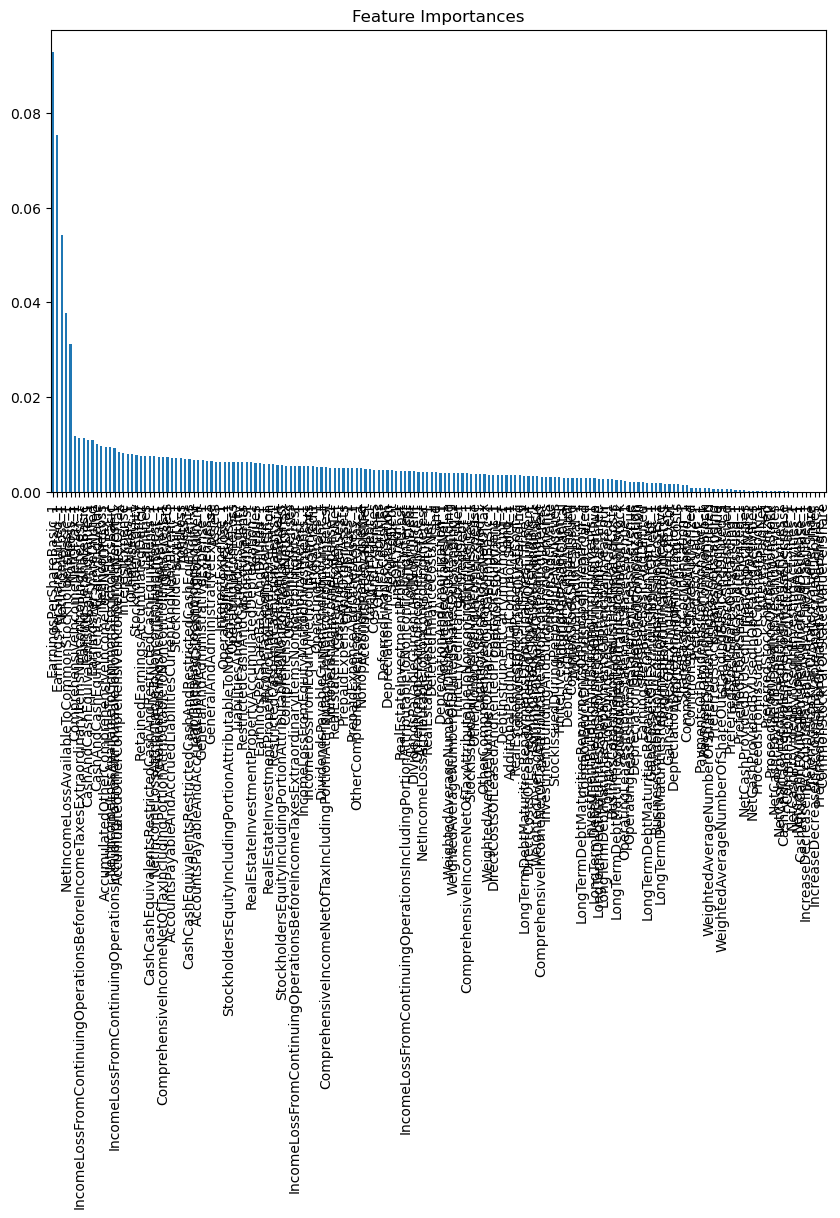

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()


In [61]:
pd.DataFrame(feature_importances).to_csv('feature_impo_2.csv',index=True)

### No shift

In [ ]:
def everything(df_list,lvl1,lvl2,shift,chunk,threshold,target_shift,testsize):
    df_new_list = num_to_cik(df_list)
    merged_df = Convertor_Multiple(df_new_list)
    na_maxed = na_max(merged_df,threshold)
    df_1 = Step01_CikFramesEpsDrop(na_maxed)
    df_2 = Step02_PercentageDifference(df_1)
    merged = process_in_chunks(df_2,lvl1,lvl2,shift,chunk)
    df_targeted=Step04_TargetDropNA(merged,lvl1,lvl2,target_shift)
    df_shuffled = df_targeted.sample(frac=1, random_state=42)
    train_set, test_set = train_test_split(df_shuffled, test_size=testsize, random_state=42)
    df = train_set
    df2 = test_set
    rf_model, train_accuracy, train_roc_auc = train_random_forest(df, 'target')
    feature_importances = rf_model.feature_importances_
    # Create a pandas series with the feature importances
    importances = pd.Series(feature_importances, index=df.columns[:-1])  # assuming last column is 'target'
    # Sort the feature importances in descending order
    sorted_importances = importances.sort_values(ascending=False)

    # Print the feature importances
    print("Feature Importances:\n", sorted_importances)
    save_model(rf_model, 'random_forest_classifier.joblib')
    rf_model_loaded = load_model('random_forest_classifier.joblib')
    unseen_accuracy, unseen_roc_auc = evaluate_model(rf_model_loaded, df2, 'target')
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Training ROC AUC: {train_roc_auc}")
    print(f"Unseen Data Accuracy: {unseen_accuracy}")
    print(f"Unseen Data ROC AUC: {unseen_roc_auc}")
    print(df_info(df))

    return train_accuracy, train_roc_auc, unseen_accuracy, unseen_roc_auc, sorted_importances

In [67]:
df = pd.read_csv('Submissions.csv')
df_list = list(df[df['SIC']==6798]['CIK'])

In [70]:
df_new_list = num_to_cik(df_list)
merged_df = Convertor_Multiple(df_new_list)
na_maxed = na_max(merged_df,0.8)
df_1 = Step01_CikFramesEpsDrop(na_maxed)
df_2 = Step02_PercentageDifference(df_1)

Key 'us-gaap' missing in file companyfacts/CIK0000899045.json. Skipping this file.
Key 'cik' missing in file companyfacts/CIK0001781324.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001949029.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001742092.json. Skipping this file.
Key 'us-gaap' missing in file companyfacts/CIK0001967097.json. Skipping this file.


In [71]:
df_2

,CIK,Frame,AccountsPayableAndAccruedLiabilitiesCurrentAndNoncurrent,AccountsReceivableNet,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AmortizationOfFinancingCosts,Assets,BusinessCombinationAcquisitionRelatedCosts,...,RetainedEarningsAccumulatedDeficit,Revenues,SecuredDebt,ShareBasedCompensation,StockIssuedDuringPeriodValueNewIssues,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfShareOutstandingBasicAndDiluted,WeightedAverageNumberOfSharesOutstandingBasic
0,3499,CY2012Q3,0.257,0.781,0.000,0.000,0.0,0.0,0.002,0.0,...,-0.001,0.000,0.0,0.0,0.0,-0.001,0.001,0.000,0.0,0.000
1,3499,CY2012Q4,-0.172,-0.403,0.000,-0.086,0.0,0.0,-0.161,0.0,...,-0.078,0.000,0.0,0.0,0.0,-0.074,-0.088,0.000,0.0,0.000
2,3499,CY2013Q1,0.145,0.217,2.698,0.000,0.0,0.0,0.002,0.0,...,0.000,0.000,0.0,0.0,0.0,0.010,0.010,0.000,0.0,0.000
3,3499,CY2013Q2,-0.225,-0.032,-0.409,0.013,0.0,0.0,-0.011,0.0,...,-0.003,0.000,0.0,0.0,0.0,-0.007,-0.007,0.000,0.0,0.000
4,3499,CY2013Q3,0.320,0.000,-0.920,0.000,0.0,0.0,0.001,0.0,...,-0.001,0.000,0.0,0.0,0.0,-0.008,-0.008,0.000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8152,0001903382,CY2023Q3,0.000,0.000,0.000,-0.008,0.0,0.0,0.007,0.0,...,0.000,-0.008,0.0,0.0,0.0,-0.013,-0.001,0.000,0.0,0.000
8153,0001939433,CY2023Q2,3.770,0.000,0.000,0.234,0.0,0.0,1.127,0.0,...,3.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000
8154,0001939433,CY2023Q3,-0.101,0.000,0.000,0.190,0.0,0.0,-0.068,0.0,...,0.750,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000
8155,0001946997,CY2023Q3,0.000,0.000,0.000,0.159,0.0,0.0,-0.004,0.0,...,14.179,0.000,0.0,0.0,0.0,-0.004,0.000,0.000,0.0,0.000


In [75]:
def asd(df,lvl1,lvl2):
    df = pd.pivot_table(df, index=[lvl1,lvl2])
    df['target_lag'] = df.groupby(level=lvl1)['EarningsPerShareBasic'].shift(-1)
    df['target'] = 0
    df.loc[df['EarningsPerShareBasic'] < df[df.columns[-2]], 'target'] = 1
    df.loc[df['EarningsPerShareBasic'] > df[df.columns[-2]], 'target'] = 0
    df = df.drop('target_lag',axis=1)
    df = df.reset_index()
    df = df.drop(lvl1,axis=1)
    df = df.drop(lvl2,axis=1)
    df = df.dropna()
    df = df.replace([np.inf, -np.inf, np.nan], 0).round(2)
    return df

In [76]:
df_3 = asd(df_2,'CIK','Frame')

In [77]:
df_3

,AccountsPayableAndAccruedLiabilitiesCurrentAndNoncurrent,AccountsReceivableNet,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AmortizationOfFinancingCosts,Assets,BusinessCombinationAcquisitionRelatedCosts,CashAndCashEquivalentsAtCarryingValue,CashAndCashEquivalentsPeriodIncreaseDecrease,...,Revenues,SecuredDebt,ShareBasedCompensation,StockIssuedDuringPeriodValueNewIssues,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfShareOutstandingBasicAndDiluted,WeightedAverageNumberOfSharesOutstandingBasic,target
0,0.26,0.78,0.00,0.00,0.0,0.0,0.00,0.0,0.04,0.0,...,0.00,0.0,0.0,0.0,-0.00,0.00,0.0,0.0,0.0,1
1,-0.17,-0.40,0.00,-0.09,0.0,0.0,-0.16,0.0,-0.30,0.0,...,0.00,0.0,0.0,0.0,-0.07,-0.09,0.0,0.0,0.0,0
2,0.14,0.22,2.70,0.00,0.0,0.0,0.00,0.0,0.04,0.0,...,0.00,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.0,1
3,-0.22,-0.03,-0.41,0.01,0.0,0.0,-0.01,0.0,-0.10,0.0,...,0.00,0.0,0.0,0.0,-0.01,-0.01,0.0,0.0,0.0,1
4,0.32,0.00,-0.92,0.00,0.0,0.0,0.00,0.0,0.05,0.0,...,0.00,0.0,0.0,0.0,-0.01,-0.01,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8152,0.00,0.00,0.00,-0.01,0.0,0.0,0.01,0.0,0.12,0.0,...,-0.01,0.0,0.0,0.0,-0.01,-0.00,0.0,0.0,0.0,0
8153,3.77,0.00,0.00,0.23,0.0,0.0,1.13,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0
8154,-0.10,0.00,0.00,0.19,0.0,0.0,-0.07,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0
8155,0.00,0.00,0.00,0.16,0.0,0.0,-0.00,0.0,-0.00,0.0,...,0.00,0.0,0.0,0.0,-0.00,0.00,0.0,0.0,0.0,0


In [79]:
df_shuffled = df_3.sample(frac=1, random_state=42)
train_set, test_set = train_test_split(df_shuffled, test_size=0.3, random_state=42)
df = train_set
df2 = test_set
rf_model, train_accuracy, train_roc_auc = train_random_forest(df, 'target')
feature_importances = rf_model.feature_importances_
# Create a pandas series with the feature importances
importances = pd.Series(feature_importances, index=df.columns[:-1])  # assuming last column is 'target'
# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)
print("Feature Importances:\n", sorted_importances)
save_model(rf_model, 'random_forest_classifier.joblib')
rf_model_loaded = load_model('random_forest_classifier.joblib')
unseen_accuracy, unseen_roc_auc = evaluate_model(rf_model_loaded, df2, 'target')
print(f"Training Accuracy: {train_accuracy}")
print(f"Training ROC AUC: {train_roc_auc}")
print(f"Unseen Data Accuracy: {unseen_accuracy}")
print(f"Unseen Data ROC AUC: {unseen_roc_auc}")
print(df_info(df))

Feature Importances:
 EarningsPerShareBasic                                     0.104334
EarningsPerShareDiluted                                   0.097408
NetIncomeLossAvailableToCommonStockholdersBasic           0.059866
NetIncomeLoss                                             0.046898
ProfitLoss                                                0.038885
                                                            ...   
NetCashProvidedByUsedInFinancingActivities                0.000191
CommonStockParOrStatedValuePerShare                       0.000118
NetCashProvidedByUsedInInvestingActivities                0.000047
PreferredStockParOrStatedValuePerShare                    0.000031
IncreaseDecreaseInAccountsPayableAndAccruedLiabilities    0.000013
Length: 88, dtype: float64
Training Accuracy: 0.7402218330414477
Training ROC AUC: 0.8193064559438413
Unseen Data Accuracy: 0.7401960784313726
Unseen Data ROC AUC: 0.8122053350188444
(0.0, (5709, 89))


In [84]:
pd.DataFrame(sorted_importances).to_csv('feature_impo_3.csv',index=True)

In [85]:
sorted_importances

EarningsPerShareBasic                                     0.104334
EarningsPerShareDiluted                                   0.097408
NetIncomeLossAvailableToCommonStockholdersBasic           0.059866
NetIncomeLoss                                             0.046898
ProfitLoss                                                0.038885
                                                            ...   
NetCashProvidedByUsedInFinancingActivities                0.000191
CommonStockParOrStatedValuePerShare                       0.000118
NetCashProvidedByUsedInInvestingActivities                0.000047
PreferredStockParOrStatedValuePerShare                    0.000031
IncreaseDecreaseInAccountsPayableAndAccruedLiabilities    0.000013
Length: 88, dtype: float64

In [87]:
df['target'].sum()

2636

In [88]:
df['target']

5552    0
2498    0
3215    0
3515    0
1464    1
       ..
5740    1
1960    1
6902    0
6457    0
6316    0
Name: target, Length: 5709, dtype: int64